In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from pathlib import Path
data_dir = Path('data/')
os.listdir(data_dir)

['segged2.png',
 'background_segmentation',
 'elythra_segmented',
 'elythra_segmentation',
 'seg_results.csv',
 'Rotated_Elythra',
 'elythra.png',
 'segged3.png',
 '.ipynb_checkpoints',
 'BeetleMeasurements.csv']

In [3]:
org_img = data_dir/'elythra.png'
os.path.exists(org_img)

True

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

### Original Image of the Elythra

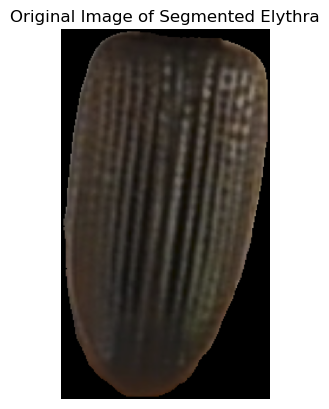

In [5]:
image = cv2.imread(org_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title("Original Image of Segmented Elythra")
plt.imshow(image)
plt.axis('off')
plt.show()

### Rotation + Cropping

In [6]:
def edge_detection(image, low_thresh=50, high_thresh=150, apertureSize=3):
    return cv2.Canny(image, low_thresh, high_thresh, apertureSize)

((297.56097412109375, 555.4512329101562), (578.3298950195312, 1091.61572265625), 6.340191841125488)
[[ -50 1065]
 [  70  -18]
 [ 645   44]
 [ 524 1129]]
6.340191841125488
Height : 1089 pixels
Width  : 579 pixels
Area   : 529287 pixels


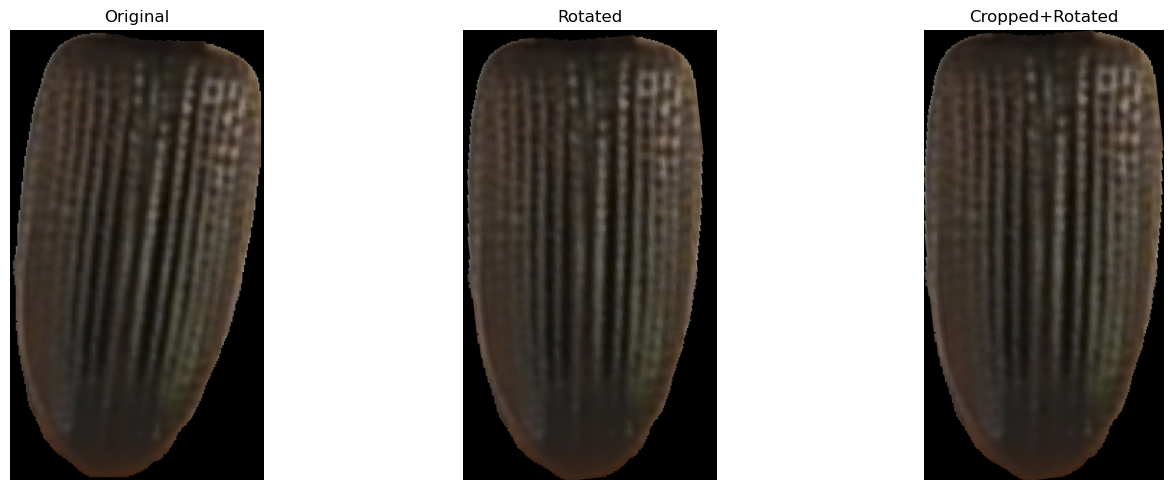

In [7]:
image = cv2.imread(org_img)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = edge_detection(gray)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

border_only = np.zeros_like(gray)

cv2.drawContours(border_only, contours, -1, 255, 1)
filled_contours = np.zeros_like(gray)

cv2.drawContours(filled_contours, contours, -1, 255, thickness=cv2.FILLED)
area = np.sum(filled_contours == 255)

rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
print(rect)
print(box)
angle = rect[-1]

print(angle)

if angle < - 45:
    angle = 90 - angle
    
else:
    angle = angle

(h, w) = gray.shape[:2]
center = (w // 2, h // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

rotated_gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
rotated_edges = edge_detection(rotated_gray, 100, 200, 3)
coords = np.column_stack(np.where(rotated_edges > 0))

(x_min, y_min) = coords.min(axis=0)
(x_max, y_max) = coords.max(axis=0)

cropped_image = rotated[x_min:x_max+1, y_min:y_max+1]
h, w, _ = cropped_image.shape

print(f"Height : {h} pixels")
print(f"Width  : {w} pixels")
print(f"Area   : {area} pixels")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.title("Rotated")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title("Cropped+Rotated")
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
output_dir = data_dir/"Rotated_Elythra"
output_filename = 'cropped_image.jpg'
output_path = os.path.join(output_dir, output_filename)
os.makedirs(output_dir, exist_ok=True)
cv2.imwrite(output_path, cropped_image)

True

### Custom Landmarks

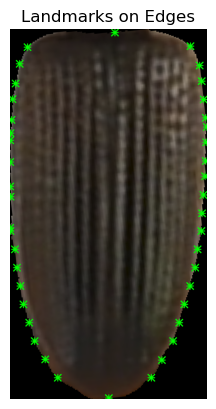

In [9]:
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
edges = edge_detection(gray) 
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(gray)
cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)

height, width = gray.shape
partitions = 20
step = height // partitions

landmarks = []
label = 1

for i in range(partitions):
    y_start = i * step
    y_end = (i + 1) * step if i != partitions-1 else height
    vertical_slice = mask[y_start:y_end, :]

    edge_points = np.column_stack(np.where(vertical_slice > 0))
    
    if len(edge_points) > 0:
        edge_points[:, 0] += y_start
        leftmost = edge_points[np.argmin(edge_points[:, 1])]
        rightmost = edge_points[np.argmax(edge_points[:, 1])]

        if i == 0 or i == partitions-1:
            middle_x = width // 2
            middle_points = edge_points[(edge_points[:, 1] > middle_x - partitions) & (edge_points[:, 1] < middle_x + partitions)]
            if len(middle_points) > 0:
                middle = middle_points[len(middle_points) // 2]
                landmarks.append((middle, label))
                label += 1

        landmarks.append((leftmost, label))
        label += 1
        landmarks.append((rightmost, label))
        label += 1

landmarks.sort(key=lambda x: (x[0][0], x[0][1]))
output_image = cropped_image.copy()
for point, lbl in landmarks:
    cv2.drawMarker(output_image, (point[1], point[0]), (0, 255, 0), markerType=cv2.MARKER_STAR, thickness=2)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title('Landmarks on Edges')
plt.axis('off')
plt.show()

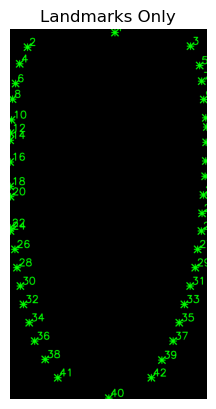

In [10]:
black_image = np.zeros((height, width, 3), dtype=np.uint8)

for point, lbl in landmarks:
    cv2.drawMarker(black_image, (point[1], point[0]), (0, 255, 0), markerType=cv2.MARKER_STAR, thickness=2)
    cv2.putText(black_image, str(lbl), (point[1] + 5, point[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
plt.title('Landmarks Only')
plt.axis('off')
plt.show()
